In [1]:
from __future__ import print_function
from __future__ import division
from gensim.models import Doc2Vec, Word2Vec
import lib.text_extraction as te
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from lib.parallelize import parallelize
from collections import OrderedDict
import lib.embedding as em
import lib.words as wd
from lib.utils import list_dir_full
import pandas as pd
import numpy as np
import pickle
import operator
import codecs
import math
import json
import csv
import os
import re

matplotlib.style.use('ggplot')
%matplotlib inline

labels = ['poteri', 'scadenza', 'assemblea', 'clausola', 'non_riconducibile']
labels2 = ['poteri', 'assemblea', 'clausola', 'non_riconducibile']

Using TensorFlow backend.


## Sentencing

In [2]:
test_dir = '../extraction/esempi_descrizioni/'

filenames = os.listdir(test_dir)
full_filenames = list_dir_full(test_dir)

#txts = [te.extract_text(f, do_ocr=False, pages=-1) for f in full_filenames]

txts = parallelize(te.extract_text)(full_filenames, do_ocr=False, pages=-1) #Doesn't work with do_ocr=True

[Errno 21] Is a directory: '../extraction/esempi_descrizioni/Originals'
[Errno 21] Is a directory: '../extraction/esempi_descrizioni/.ipynb_checkpoints'


In [ ]:
for i, txt in zip(filenames, txts):
    print('Documento ', i)
    print(txt[:1000])

In [ ]:
extracted_txts_dir = '../extraction/esempi_extracted/'

for fn, txt in zip(filenames, txts):
    utxt = wd.to_utf8(txt)
    with codecs.open(os.path.join(extracted_txts_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write(utxt)


In [ ]:
sentences_dir = '../extraction/esempi_sentences/'

sentences = [wd.sentences_doc(txt) for txt in txts]

for fn, txt in zip(filenames, sentences):
    with codecs.open(os.path.join(sentences_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write('\n'.join(s.replace('\n',' ').strip() for s in txt if s.strip()))

## Saving sentences

In [ ]:
sentenced_txts = [wd.sentences_doc(txt) for txt in txts]

In [ ]:
def sentence_label_csv_empty(filenames, sentenced_txts, csv_out, sep=u'\t', min_len=10):
    csv_out.write(sep.join([u'filename',u'sent_index',u'sentence',u'label']) + u'\n')
    for f, sents in zip(filenames, sentenced_txts):
        for i, sent in enumerate(sents):
            clean_sent = sent.replace(sep,u'').replace(u'\n',u' ').strip()
            if len(clean_sent)>=min_len:
                csv_out.write(sep.join([u'{}',u'{}',u'{}',u'non_riconducibile']).format(f,i,clean_sent)+u'\n')
    

In [ ]:
csv_filename = '../extraction/sentence_labels.csv'
with codecs.open(csv_filename, 'w', encoding='utf-8') as csv_out:
    sentence_label_csv_empty(os.listdir(test_dir), sentenced_txts, csv_out)

In [ ]:
df = pd.read_csv(csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [ ]:
df.groupby(['filename'])['sentence'].apply(list).to_dict()

In [ ]:
labelled_filename = '../extraction/sentence_manual_labels.csv'
dfm = pd.read_csv(labelled_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

## Save to excel files

In [ ]:
def sentences_to_excel(sentences, filename, out_dir, sep=u'\t', min_len=10):
    clean_sents = [sent.replace(sep,u'').replace(u'\n',u' ').strip() for sent in sentences]
    clean_sents = [sent for sent in clean_sents if len(sent)>=min_len]
    df = pd.DataFrame({'sentence':clean_sents,'label':['non_riconducibile']*len(clean_sents)})
    df.to_excel(os.path.join(out_dir, os.path.basename(filename)[:-3]+'xlsx'), index=False, encoding='utf-8')

In [ ]:
files_to_label = [f for f in list_dir_full('../extraction/files_to_label/') if f.endswith('.pdf')]
txts_to_label = [te.extract_text(f, do_ocr=True, pages=-1) for f in files_to_label]
sentences_to_label = [wd.sentences_doc(txt) for txt in txts_to_label]

In [ ]:
for f, s in zip(files_to_label, sentences_to_label):
    sentences_to_excel(s, f, '../extraction/excels_to_label/')

In [ ]:
dfm = pd.read_csv('../extraction/sentence_manual_labels3.csv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [ ]:
snts = dfm.groupby('filename')['sentence'].apply(list)
lbls = dfm.groupby('filename')['label'].apply(list)
for f in snts.keys():
    cur_df = pd.DataFrame({'sentence':snts.loc[f],
                            'label':['non_riconducibile' if l == 'non_rilevante' else l for l in lbls.loc[f]]})
    cur_df.to_excel('../extraction/excels_labelled_from_csv/'+f+'.xlsx', index=False, encoding='utf-8')

In [2]:
def build_dataframe_from_excels(filenames):
    dfs = [pd.read_excel(f, encoding='utf-8') for f in filenames]
    filename_col = [os.path.basename(f)[:-5] for f,df in zip(filenames, dfs) for _ in range(df.shape[0])]
    sent_index_col = [i for df in dfs for i in range(df.shape[0])]
    dfs_conc = pd.concat(dfs, ignore_index=True, axis=0)
    sentence_col = dfs_conc['sentence']
    label_col = dfs_conc['label']
    #print('{} {} {} {}'.format(len(filename_col), len(sent_index_col), len(sentence_col), len(label_col)))
    return pd.DataFrame(OrderedDict([
        ('filename',filename_col),
        ('sent_index', sent_index_col),
        ('sentence', sentence_col),
        ('label', label_col)
    ]))

In [18]:
x_files_n = [f for f in list_dir_full('../extraction/excels_labelled/') if f.endswith('.xlsx')]
x_files_o = [f for f in list_dir_full('../extraction/excels_labelled/originals/') if f.endswith('.xlsx')]
x_files = (x_files_n +x_files_o)[:30]
dfx = build_dataframe_from_excels(x_files)

In [19]:
len(x_files)

30

In [20]:
dfx.to_csv('../extraction/merged_xlsx.csv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE, index=False)

## Experiments on labelled sentences

In [2]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def splitted_words_lower(sentences):
    return [[w.lower() for w in wd.splitted_words_utf8(s)] for s in sentences]


In [3]:
labeled_csv_filename = '../extraction/merged_xlsx.csv' #'../extraction/sentence_manual_labels3.csv'

ldf = pd.read_csv(labeled_csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [4]:
ldf

,filename,sent_index,sentence,label
0,4907876150001,0,Repertorio n47163 Raccolta n20658 ATTO COSTITU...,non_riconducibile
1,4907876150001,1,"Gli stessi comparenti, con il presente atto, c...",non_riconducibile
2,4907876150001,2,"I) Viene costituita, in conformità al disposto...",non_riconducibile
3,4907876150001,3,Per espressa previsione della compagine social...,non_riconducibile
4,4907876150001,4,"La società risulta essere, altresì, come unani...",non_riconducibile
5,4907876150001,5,"1 Dott Ambrogio Romano NOTAIO Inoltre, come de...",non_riconducibile
6,4907876150001,6,"II) La società ha sede legale in Benevento, co...",non_riconducibile
7,4907876150001,7,Ai fini dell'espletamento delle formalità pubb...,non_riconducibile
8,4907876150001,8,"2) avvalersi prevalentemente, nello svolgiment...",non_riconducibile
9,4907876150001,9,"3) avvalersi prevalentemente, nello svolgiment...",non_riconducibile


In [7]:
ldf.groupby('label').count()

,filename,sent_index,sentence
label,,,
assemblea,577,577,577
clausola,584,584,584
non_riconducibile,3790,3790,3790
poteri,587,587,587
scadenza,28,28,28


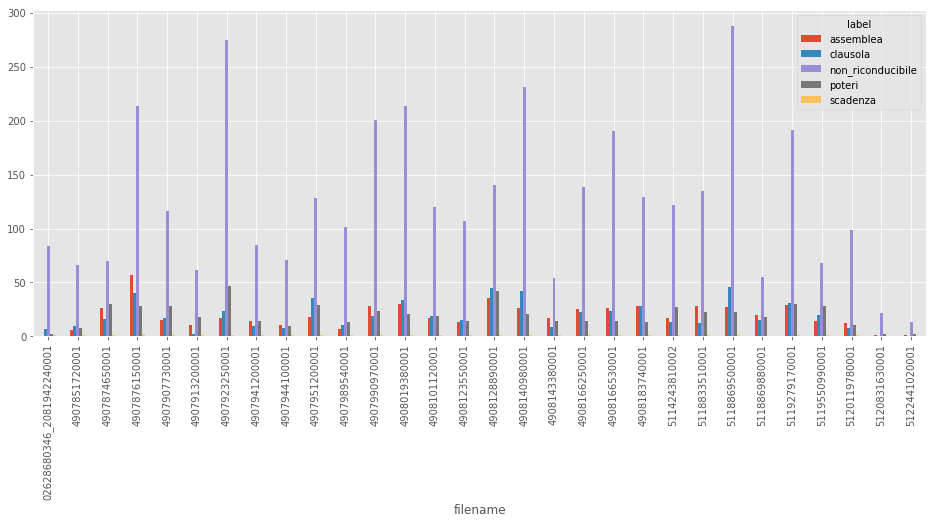

In [8]:
df25 = ldf.groupby(['filename', 'label']).size().reset_index(name="Count")
df35 = pd.pivot_table(df25,  values='Count',  columns=['label'], index='filename')
#df45 = pd.pivot_table(df25,  values='Count',  columns=['filename'], index='label')
df35.plot(kind="bar", figsize=(16,6))
plt.show()
#df45.plot(kind="bar", figsize=(16,6))
#plt.show()

## Sentence Word embedding (dataset creation)

In [5]:
no_s_df = ldf.copy()
no_s_df['label'] = ldf['label'].apply(lambda l: 'non_riconducibile' if l == 'scadenza' else l)

In [6]:
splitted_sentences = wd.tokenize_sentences(no_s_df['sentence'], min_words=1)
labels_sentences = [labels2.index(l) for l in no_s_df['label']]
print('Sentences: {}\nLabels: {}'.format(len(splitted_sentences), len(labels_sentences)))

Sentences: 5566
Labels: 5566


In [7]:
fnw = em.first_n_words(splitted_sentences, 4998)
permitted_words = [e[0] for e in fnw]
reduced_sentences = list(em.reduce_dictionary(splitted_sentences, permitted_words, min_words=1))
reduced_dictionary = em.build_dictionary(reduced_sentences, start_index=1) #start from 1, 0 is padding!
int_sentences = [[reduced_dictionary[w] for w in sent] for sent in reduced_sentences]

In [28]:
np.percentile([len(s) for s in int_sentences], 99.9)

116.4350000000004

In [29]:
max(reduced_dictionary.values())

4999

In [31]:
reduced_dictionary

{u'utilizzata': 1996,
 u'gegno': 4953,
 u'utilizzate': 817,
 u'rinunziare': 2505,
 u'comunque': 535,
 u'campioni': 4185,
 u'motivazione': 1475,
 u'unico': 303,
 u'consiste': 2947,
 u'convegni': 3417,
 u'speculazione': 573,
 u'attribuire': 2601,
 u'merceologiche': 3373,
 u'rappresenta': 3985,
 u'francesco': 207,
 u'assemblea': 311,
 u'francesca': 2647,
 u'nega': 1114,
 u'assemblee': 1074,
 u'stratore': 1724,
 u'taio': 2780,
 u'parcheggi': 1839,
 u'riservata': 3236,
 u'presenta': 2769,
 u'figli': 2511,
 u'presente': 90,
 u'egli': 2900,
 u'determinando': 1972,
 u'fiscali': 3827,
 u'presenti': 781,
 u'ali': 3346,
 u'xx': 4517,
 u'seguire': 3329,
 u'firmato': 2013,
 u'loro': 3683,
 u'fronte': 911,
 u'conse': 4961,
 u'semprech\xe8': 3084,
 u'firmati': 2067,
 u'castellammare': 1700,
 u'carapelle': 2030,
 u'pensione': 4740,
 u'idraulica': 4298,
 u'cia': 4601,
 u'alluminio': 4172,
 u'consortili': 3424,
 u'sopraelencate': 4811,
 u'mutualistiche': 2240,
 u'consortile': 4248,
 u'denominazione': 41

In [34]:
with codecs.open('../dictionaries/first_5000_words_extraction.json', 'w', encoding='utf-8') as o:
    json.dump(reduced_dictionary,o)

In [30]:
with open('../extraction/dataset.p', 'wb') as o:
    pickle.dump([int_sentences, labels_sentences], o)

## Random tests section

In [8]:
sdf = ldf.loc[ldf['label'] == 'scadenza']   #[['sentence','label']] # if u'primo esercizio' in l[0]

In [9]:
def is_scadenza(s):
    return re.match(r'.*primo\s+?esercizio.*', s) != None

In [10]:
len(ldf.loc[lambda s: [ is_scadenza(s) for s in ldf['sentence']]])

27

In [7]:
sentences_rows = {l:ldf.loc[ldf['label'] == l]['sentence'] for l in labels}

splits = {l:splitted_words_lower(sentences_rows[l]) for l in labels}

### Sentence and word embedding clusters

In [66]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Word2Vec
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
from lib.embedding import first_n_words
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import LocalOutlierFactor
from pylab import figure
import random as rnd
n_clusters = 5

In [9]:
# Sentence embedding model
gensim_sentence_iter = (LabeledSentence(s, [i]) for i,s in enumerate(splitted_sentences))
se_model = Doc2Vec(gensim_sentence_iter, size=100, window=8, min_count=5, workers=4)
se_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [10]:
sentence_vectors = [se_model.infer_vector(s) for s in splitted_sentences]

In [11]:
kmeans = KMeans(len(labels))
kmeans.fit(sentence_vectors)
kmeans_sv_labels = kmeans.labels_
agg = AgglomerativeClustering(len(labels), affinity='cosine', linkage='average')
agg.fit(sentence_vectors)
agg_sv_labels = agg.labels_

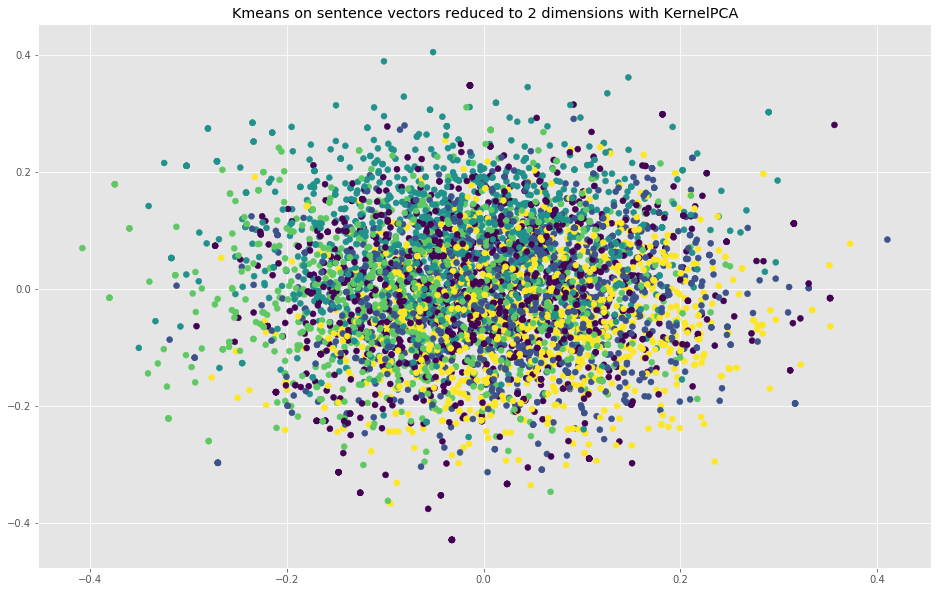

In [12]:
pca = KernelPCA(2, kernel='cosine')
sv2_pca = pca.fit_transform(sentence_vectors)
plt.figure(figsize=(16, 10))
plt.scatter(sv2_pca[:,0], sv2_pca[:,1], c=kmeans_sv_labels)
plt.title('Kmeans on sentence vectors reduced to 2 dimensions with KernelPCA')

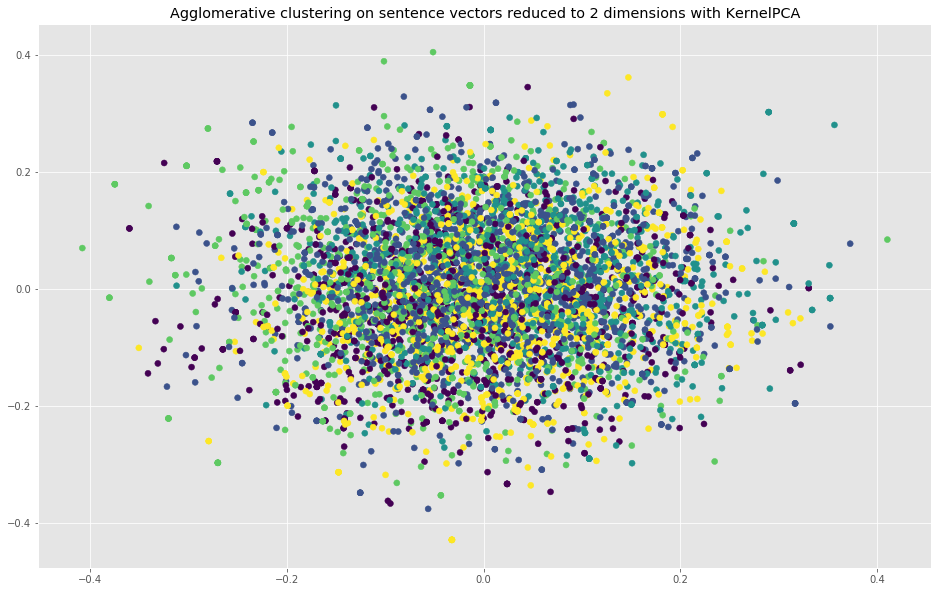

In [13]:
plt.figure(figsize=(16, 10))
plt.scatter(sv2_pca[:,0], sv2_pca[:,1], c=agg_sv_labels)
plt.title('Agglomerative clustering on sentence vectors reduced to 2 dimensions with KernelPCA')

In [14]:
tsne = TSNE(2, metric='cosine')
sv2 = tsne.fit_transform(sentence_vectors)

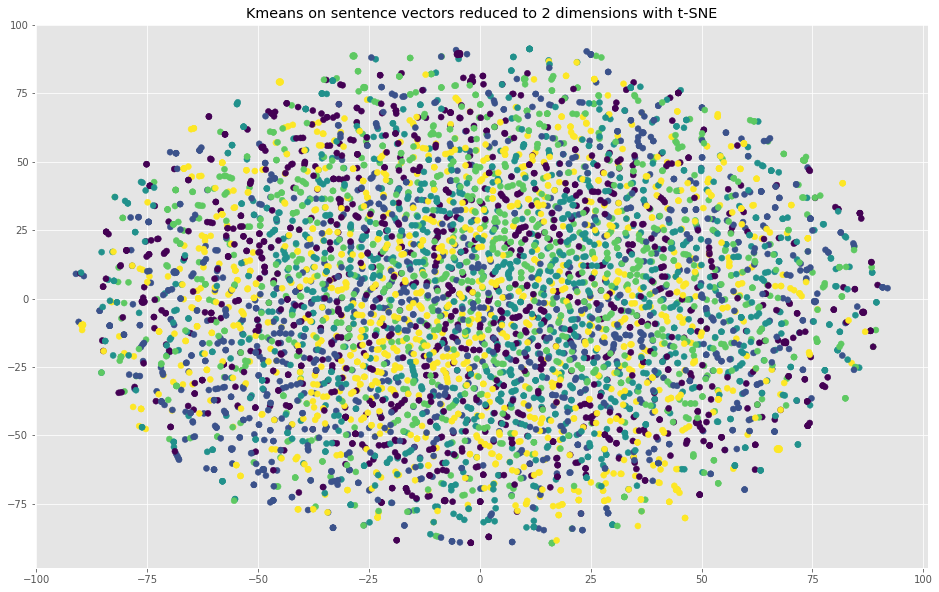

In [15]:
plt.figure(figsize=(16, 10))
plt.scatter(sv2[:,0], sv2[:,1], c=kmeans_sv_labels)
plt.title('Kmeans on sentence vectors reduced to 2 dimensions with t-SNE')

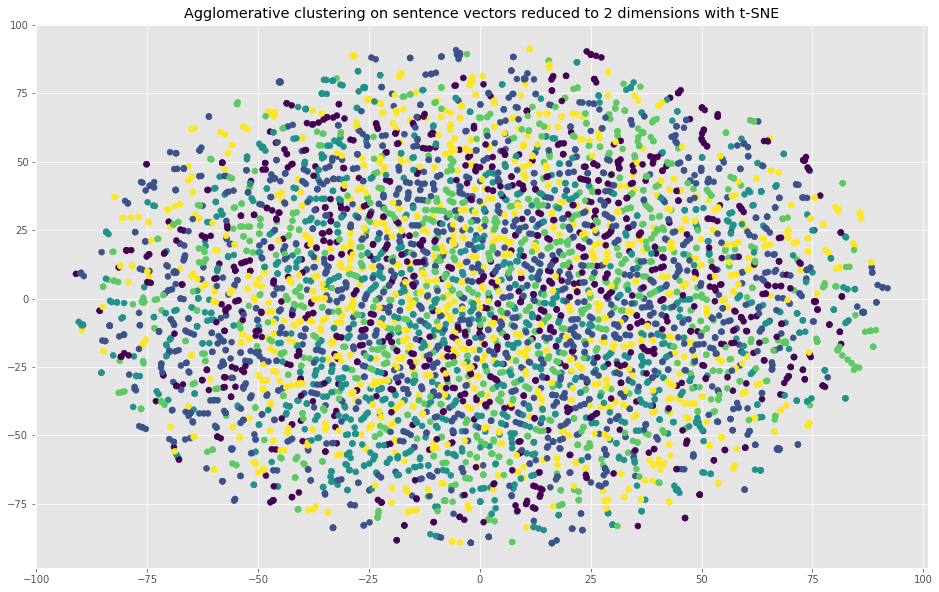

In [16]:
plt.figure(figsize=(16, 10))
plt.scatter(sv2[:,0], sv2[:,1], c=agg_sv_labels)
plt.title('Agglomerative clustering on sentence vectors reduced to 2 dimensions with t-SNE')

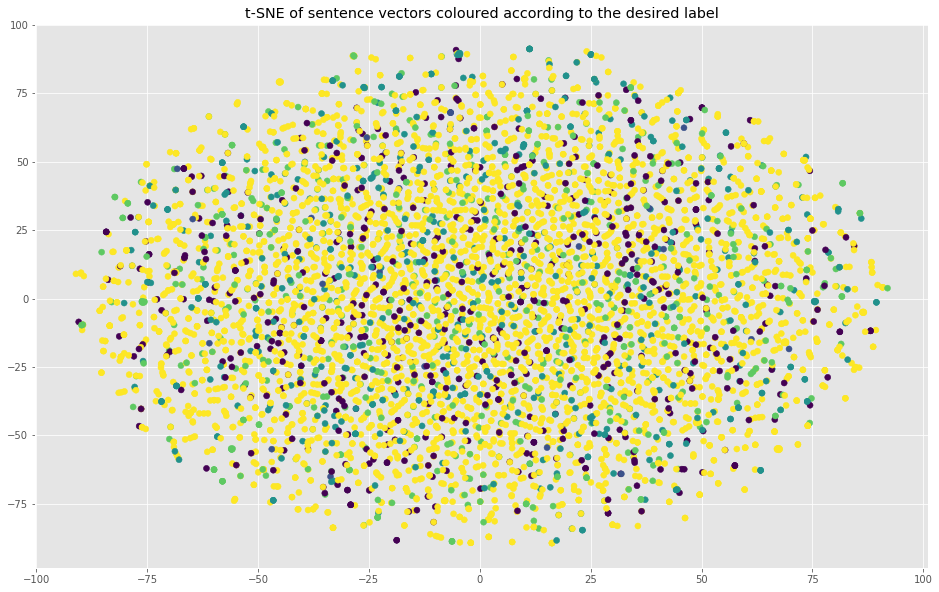

In [17]:
plt.figure(figsize=(16, 10))
plt.scatter(sv2[:,0], sv2[:,1], c=[labels.index(x) for x in ldf['label']])
#plt.legend(labels)
plt.title('t-SNE of sentence vectors coloured according to the desired label')

In [32]:
we_model =  Word2Vec(splitted_sentences, size=100, window=5, min_count=5, workers=4)
word_vectors = we_model.wv
del we_model
words = [word for word in set(w for s in splitted_sentences for w in s) if word in word_vectors]
we = [word_vectors[w] for w in words]


In [33]:
word_vectors.most_similar('assemblea')

[(u'componenti', 0.9848722219467163),
 (u'nuovo', 0.9786657094955444),
 (u'nominato', 0.9783797264099121),
 (u'inattivit\xe0', 0.9777814149856567),
 (u'pu\xf2', 0.9773961305618286),
 (u'nominati', 0.9757744073867798),
 (u'segretario', 0.9757172465324402),
 (u'amministratori', 0.9755005836486816),
 (u'membri', 0.973406195640564),
 (u'alternativamente', 0.9732491970062256)]

In [95]:
tsne = TSNE(2, metric='cosine') #KernelPCA(2, kernel='cosine')
we2 = tsne.fit_transform(we)

In [111]:
#pca = KernelPCA(20, kernel='cosine')
#we20 = pca.fit_transform(we)
tsne3 = TSNE(3, metric='cosine') #KernelPCA(2, kernel='cosine')
we3 = tsne3.fit_transform(we)

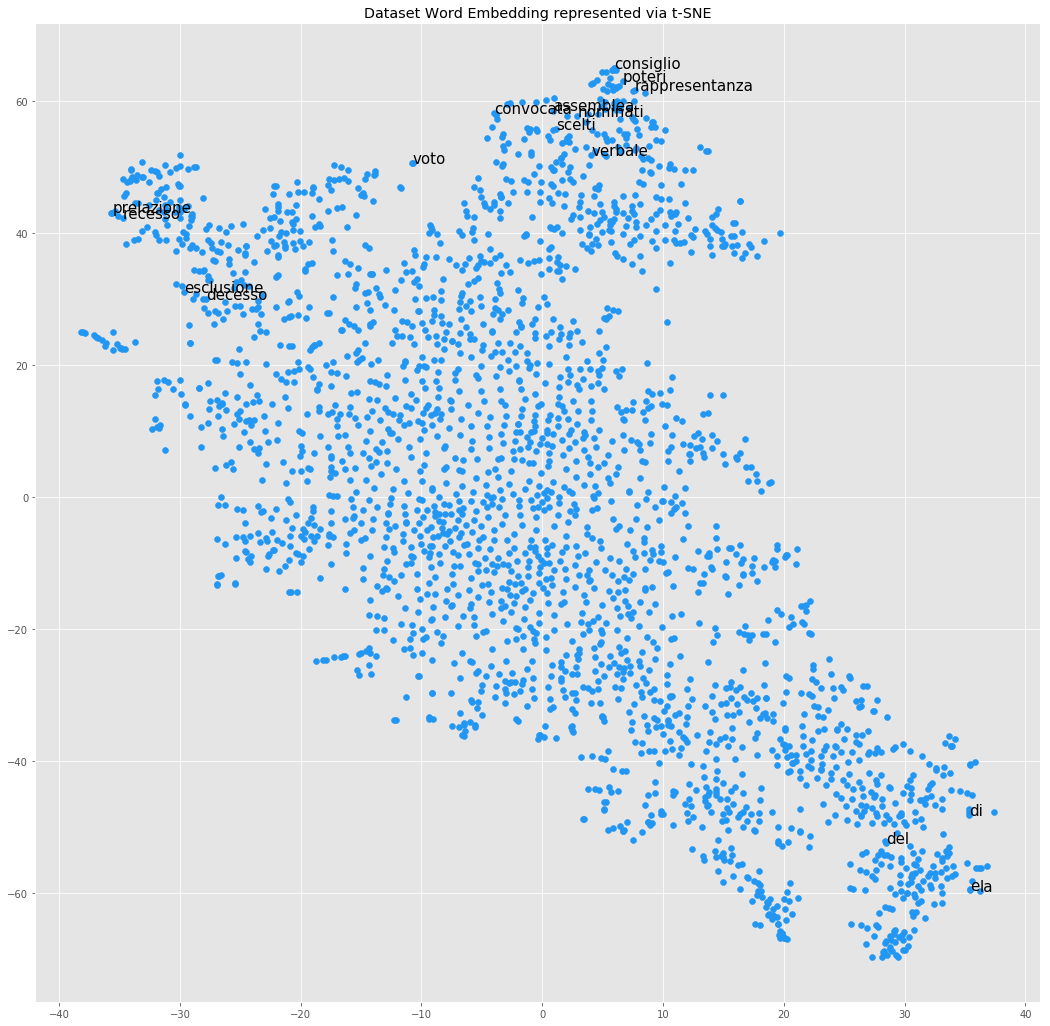

In [96]:
some_words_we = [u'assemblea', u'nominati', u'consiglio', 'convocata',
                u'poteri', u'rappresentanza', #u'organo',
              u'scelti', 'verbale', 'voto', 'recesso', 'prelazione', 'esclusione', 'decesso',
              'e', 'la', 'di', 'del'] #+ rnd.sample(k=10, population=words)

#kmeans_we2_labels = KMeans(len(labels)).fit_predict(we2)
#some_words_we = rnd.sample(words, 50)
fig, ax = plt.subplots()
fig.set_size_inches(18, 18)
ax.scatter(we2[:,0], we2[:,1], c='#2196F3') # kmeans_we2_labels)
plt.title('Dataset Word Embedding represented via t-SNE')
for txt in some_words_we:
    ax.text(we2[words.index(txt),0]+0.001,we2[words.index(txt),1]+0.001, txt, size=15, color='k')

In [99]:
# Outlier elimination
db_labels = DBSCAN(eps=8, min_samples=10).fit_predict(we3)
in_lier_indexes = [i for i,e in enumerate(db_labels) if e!=-1]
we3_in = we3[in_lier_indexes]
words_in = np.array(words)[in_lier_indexes].tolist()
#out_lier_indexes = [i for i,e in enumerate(db_labels) if e==-1]
#np.array(words)[out_lier_indexes].tolist()

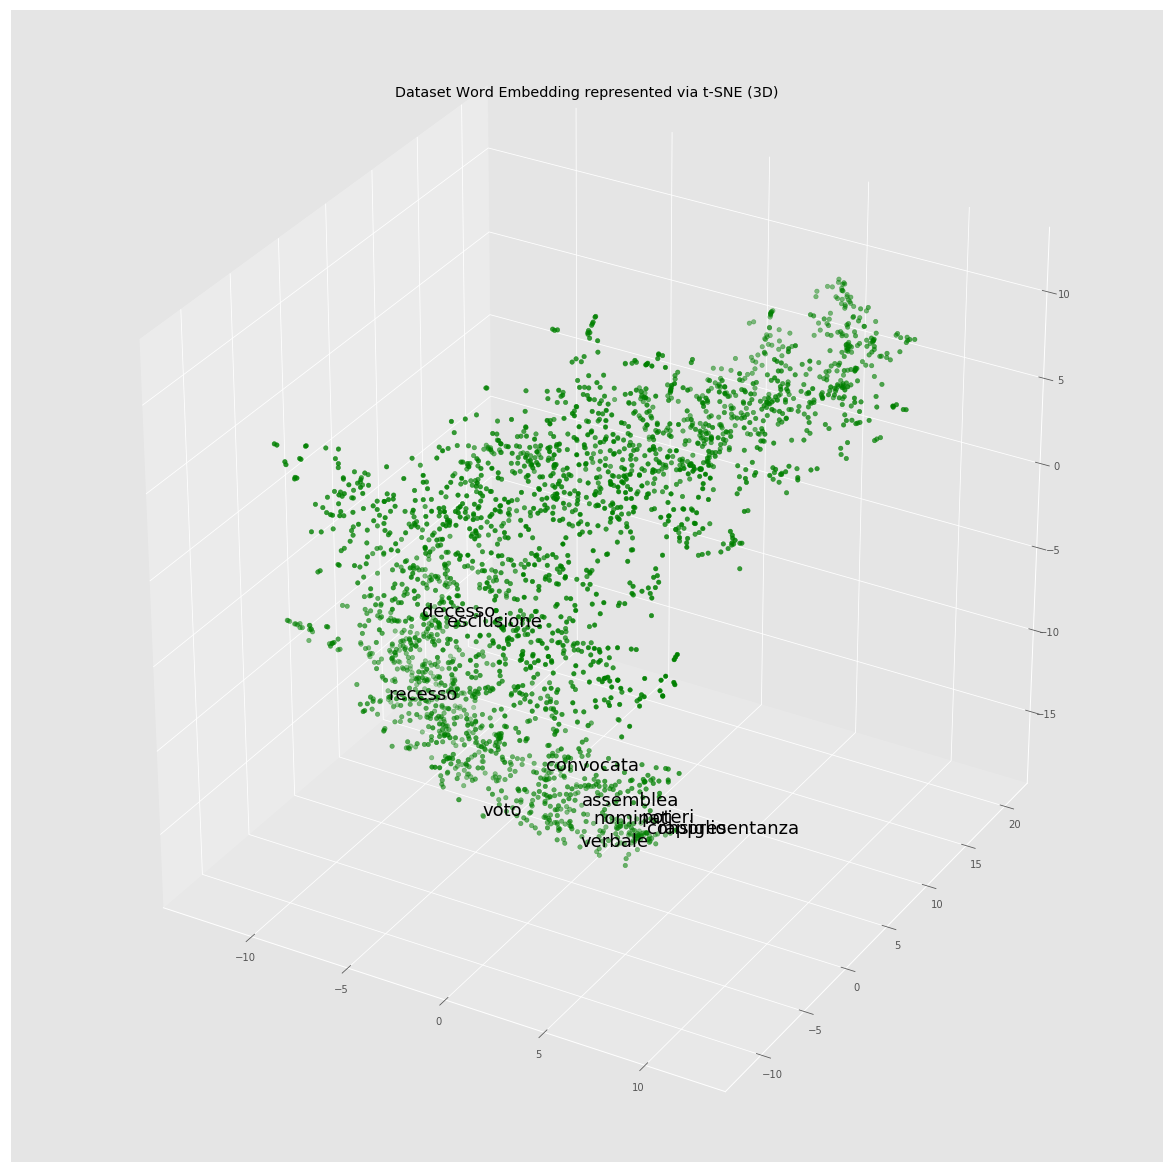

In [112]:
some_words_we_3D = [u'assemblea', u'nominati', u'consiglio', 'convocata',
                    u'poteri', u'rappresentanza',
                    u'verbale', 'voto', 'recesso', 'esclusione', 'decesso']

fig = figure(figsize=(16,16))
ax = Axes3D(fig)
ax.scatter(we3_in[:,0], we3_in[:,1], we3_in[:,2], c='g') 
for txt in some_words_we_3D:
    ax.text(we3_in[words_in.index(txt),0]+0.001,we3_in[words_in.index(txt),1]+0.001, we3_in[words_in.index(txt),2]+0.001,
            txt, size=18, zorder=1, color='k')
plt.title('Dataset Word Embedding represented via t-SNE (3D)')

In [24]:
some_words = [u'assemblea', u'nominati', u'amministrazione', u'consiglio', 'convocata',
              u'segretario', u'carica', u'poteri', u'rappresentanza', #u'organo',
              u'scelti', u'scelto', 'verbale', 'voto', 'presidente', 'recesso', 'prelazione', 'esclusione',
             'e', 'la', 'di', 'del']
#some_words = [e[0] for e in first_n_words(splitted_sentences, 10) if e[0] in word_vectors]

dim_reduct = KernelPCA(2, kernel='cosine')
dim_reduct.fit(we)

sw_wv = [word_vectors[w] for w in some_words]
sw = dim_reduct.transform(sw_wv)
swx = sw[:,0]
swy = sw[:,1]
#print(some_words)

In [25]:
pred = KMeans(4).fit_predict(sw)

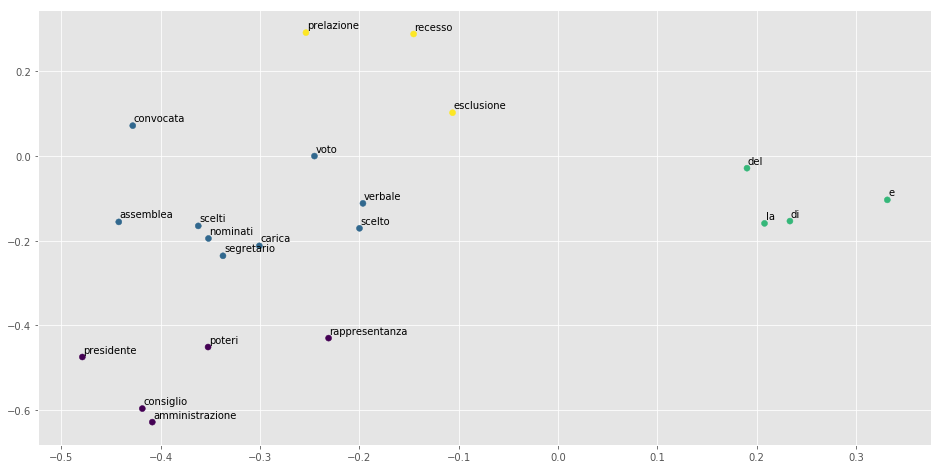

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
ax.scatter(sw[:,0], sw[:,1], c=pred)
for i, txt in enumerate(some_words):
    ax.annotate(txt, (swx[i]+0.001,swy[i]+0.01))

## Tf Idf


In [35]:
def tf(word, sentence):
    '''Term frequency in the sentence'''
    return sum(1 for w in sentence if w == word)/len(sentence)

def idf(word, documents):
    '''Inverse document frequency'''
    D = len(documents)
    den = 1+sum(1 for sentence in documents if word in sentence)
    return math.log(D/den)

def idf_memo(documents):
    '''Defines a memoized version of idf with the given set of documents'''
    word_idf = {}
    def memoized_idf(word):
        if not word in word_idf:
            word_idf[word] = idf(word, documents)
        return word_idf[word]
    return memoized_idf

def tf_idf(word, sentence, sentences):
    '''Simple tf-idf index'''
    return tf(word, sentence)*idf(word, sentences)

def tf_idf_memo(documents):
    '''Defines a memoized version of tf-idf with the given set of documents'''
    idf_memoized = idf_memo(documents)
    def tf_idf_memoized(word, sentence):
        return tf(word, sentence)*idf_memoized(word)
    return tf_idf_memoized
    

In [40]:
# On all sentences
split_sentences = [[w.lower() for w in wd.splitted_words_utf8(s)] for s in ldf['sentence']]

tf_idf_memoized = tf_idf_memo(split_sentences)

In [41]:
def sorted_tfidf_words(splitted_sentences , tf_idf_memoized):
    words = set(word for sent in splitted_sentences for word in sent)
    words_mean_tfidf = [(word, np.mean([tf_idf_memoized(word, s) for s in splitted_sentences])) for word in words]
    return sorted(words_mean_tfidf, key=operator.itemgetter(1), reverse=True)

In [42]:
sorted_words = {k:sorted_tfidf_words(v, tf_idf_memoized) for k,v in splits.items()}


In [43]:
def print_parole_tf_idf(sorted_words, n = -1):
    print(u'{:20}\t{:20}\n'.format(u'parola',u'mean tf-idf'))
    if n < 0:
        n = len(sorted_words)
    for w, score in sorted_words[:n]:
        print(u'{:20}\t{:1.4f}'.format(w,score))

In [44]:
for k,v in sorted_words.items():
    print('{}:'.format(k))
    print_parole_tf_idf(v, 40)
    print()

assemblea:
parola              	mean tf-idf         

assemblea           	0.0606
convocazione        	0.0304
l                   	0.0278
dell                	0.0274
verbale             	0.0251
voto                	0.0243
delega              	0.0239
essere              	0.0223
anche               	0.0204
presidente          	0.0194
dal                 	0.0187
o                   	0.0187
dei                 	0.0185
deve                	0.0181
da                  	0.0180
e                   	0.0173
soci                	0.0172
il                  	0.0171
in                  	0.0158
seconda             	0.0155
la                  	0.0153
per                 	0.0151
che                 	0.0151
può                 	0.0145
socio               	0.0144
del                 	0.0142
giorno              	0.0139
alla                	0.0137
di                  	0.0137
all                 	0.0132
presenti            	0.0129
un                  	0.0128
prima               	0.0128
convocata           	0

In [ ]:
'compromissoria' in [e[0] for e in sorted_words['clausola']]

In [ ]:
most_relevant_poteri_words = OrderedDict(sorted_words['poteri']) #[:8]

In [ ]:
def score_sentence_frequency(sentence, most_relevant_words):
    '''cosine distance between frequency of words in sentence and the most relevant words tf-idf'''
    counts = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        if w in counts:
            counts[w] += 1
    l = len(sentence)
    frequencies = [v/l for v in counts.values()]
    if np.linalg.norm(frequencies) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    return cosine_similarity(np.array(frequencies), np.array(most_relevant_words.values())) 
    
def score_sentence_tf_idf(sentence, most_relevant_words, tf_idf_memoized):
    '''cosine distance between tf-idf of words in sentence and the most relevant words tf-idf'''
    tfidfs = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        tfidfs[w] = tf_idf_memoized(w, sentence)
    if np.linalg.norm(tfidfs.values()) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    l = min(len(tfidfs), len(most_relevant_words))
    return cosine_similarity(np.array(tfidfs.values())[:l], np.array(most_relevant_words.values())[:l])

In [ ]:
[score_sentence_tf_idf(split, OrderedDict(sorted_words['poteri']), tf_idf_memoized) for split in splits['poteri']]

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [102]:
no_non_ric = ldf.loc[ldf['label']!='non_riconducibile']
tfidf_vect = TfidfVectorizer(strip_accents='unicode',  encoding='utf-8')
X = tfidf_vect.fit_transform(no_non_ric['sentence'])
ts2 = TruncatedSVD(n_components=2)
X_2 = ts2.fit_transform(X)
#no_non_ric

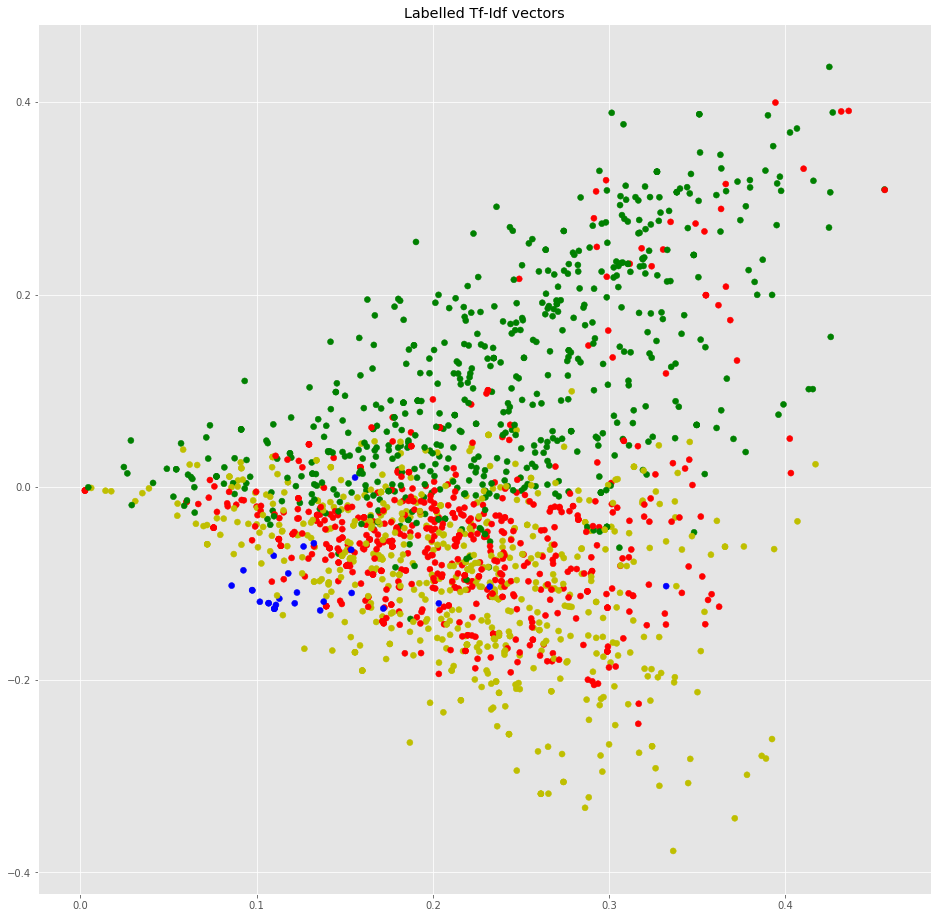

In [108]:
fig = figure(figsize=(16,16))
map_colors = ['g','b','r','y']
plt.scatter(X_2[:,0],X_2[:,1], c = [map_colors[labels.index(x)] for x in no_non_ric['label']])
plt.title('Labelled Tf-Idf vectors')

In [104]:
ts3 = TruncatedSVD(n_components=3)
X_3 = ts3.fit_transform(X)

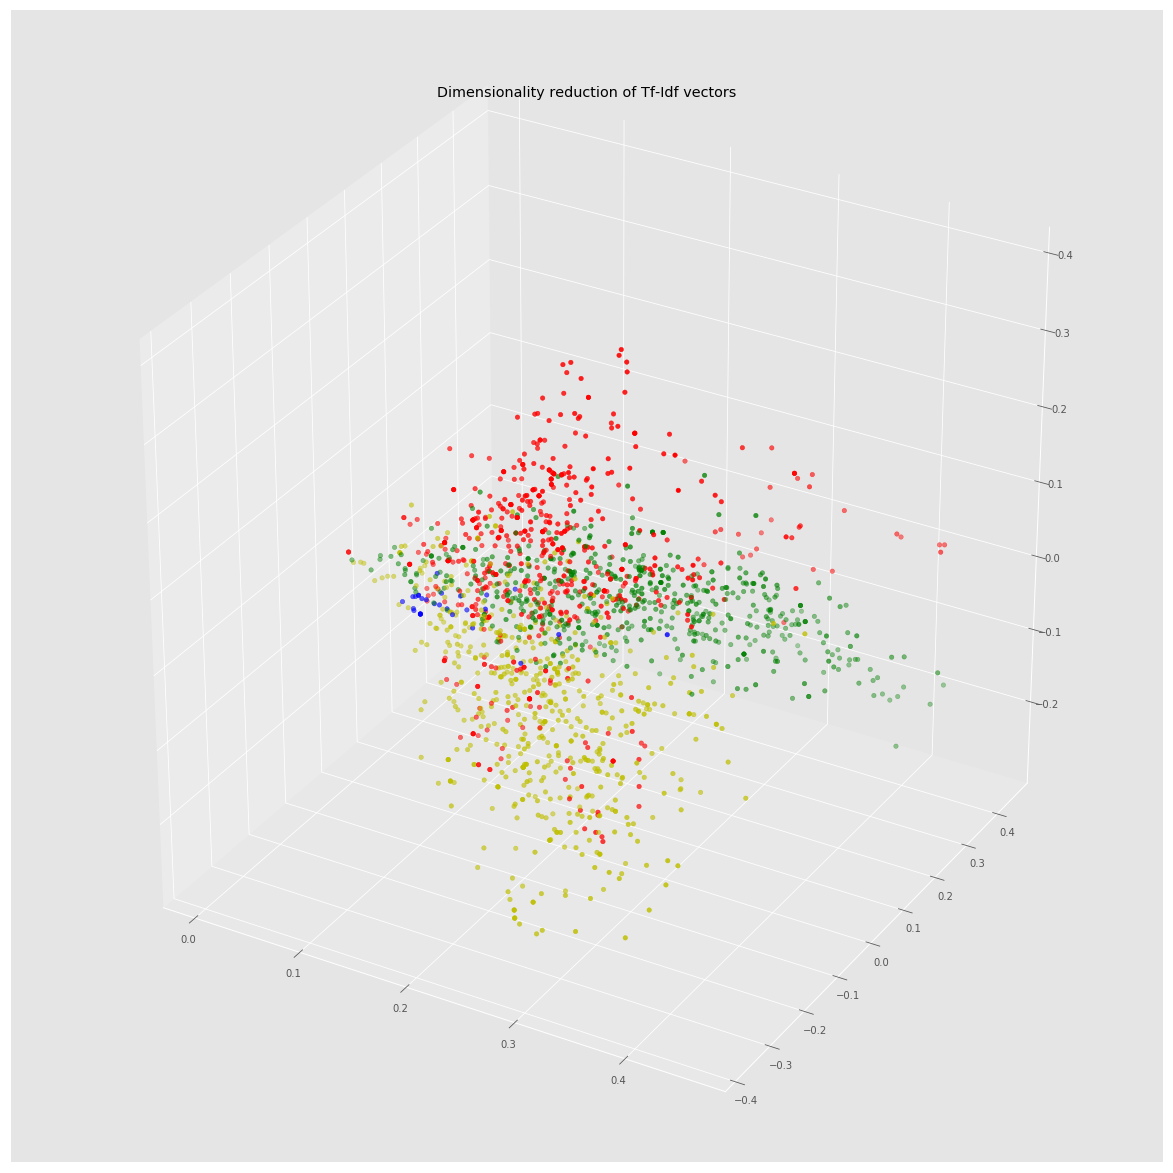

In [107]:
fig = figure(figsize=(16,16))
ax = Axes3D(fig)
ax.scatter(X_3[:,0], X_3[:,1], X_3[:,2], c=[map_colors[labels.index(x)] for x in no_non_ric['label']])
plt.title('Dimensionality reduction of Tf-Idf vectors')

## Embeddings test

In [ ]:
txts_tokenized = [wd.tokenize_doc(txt) for txt in txts]

In [ ]:
reduced_dictionary_filename = '../dictionaries/first_5000_words.json'
with open(reduced_dictionary_filename) as f:
    reduced_dictionary = set(json.load(f))

gensim_model_filename = '../models/gensim_model_5000.d2v'
gensim_model = Doc2Vec.load(gensim_model_filename)

In [ ]:
embeddings = [em.embed_document(gensim_model, txt, reduced_dictionary) for txt in txts_tokenized]

In [ ]:
sv = partial(em.sentence_vector, model=gensim_model, permitted_words=reduced_dictionary)

In [ ]:
p1 = u'All\'organo amministrativo sono conferiti i più ampi poteri, sia per la gestione ordinaria che straordinaria della Società'
p2 = u'ARTICOLO 19 - POTERI DELL\'ORGANO AMMINISTRATIVO 191 L\'organo amministrativo ha tutti i poteri di ordinaria e straordinaria amministrazione'
cosine_similarity(sv(sentence=p1.lower()),sv(sentence=p2.lower())) 

In [ ]:
mean_cosines_poteri = [np.mean([cosine_similarity(sv(sentence=split_poteri[i]), sv(sentence=split_poteri[j]))
                               for i in range(len(split_poteri)) if i != j])
                                   for j in range(len(split_poteri))]

## Word2Vec


In [ ]:
sentences_tokenized = [sent for doc in txts_tokenized for sent in doc] #i should reduce the dictionary also

In [ ]:
w2v = Word2Vec(sentences_tokenized, size=100, window=5, min_count=5, workers=4)

In [ ]:
w2v.wv['costitutivo']

In [ ]:
cosine_similarity(w2v.wv['atto'], w2v.wv['costitutivo'])

In [ ]:
w2v.most_similar('poteri')

In [ ]:
w2v.most_similar(positive=['atto','costitutivo'])

## Italian names

In [ ]:
nomi = set(n.strip().lower() for n in open('lib/nomi_italiani.txt'))
cognomi = set(n.strip().lower() for n in open('lib/cognomi.txt'))

In [ ]:
docs = [wd.tokenize_doc(txt) for txt in txts]


In [ ]:
for doc in docs:
    print([n for sent in doc for n in sent if n in cognomi])